<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/lista_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)

In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://downloads.skewed.de/apt jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,113 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,317 kB]
Hit:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRel

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132765 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgr

### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

# Redes Complexas
---

Redes selecionadas:

https://networks.skewed.de/net/jazz_collab

**Descrição:**
A rede de colaborações entre músicos de jazz e entre bandas de jazz, extraída do banco de dados digital The Red Hot Jazz Archive, abrange bandas que se apresentaram entre 1912 e 1940.

**Citação:** P. Gleiser and L. Danon, "Community Structure in Jazz." Advances in Complex Systems 6(4), 565-573 (2003)., https://doi.org/10.1142/S0219525903001067 [@sci-hub]

----

https://networks.skewed.de/net/facebook_organizations

**Descrição:** Redes de amizades entre usuários do Facebook que indicaram emprego em uma das corporações-alvo. As empresas variam em tamanho, de pequenas a grandes. Em cada instantâneo, apenas as conexões entre funcionários da mesma empresa são incluídas.

**Citação:**
M. Fire, and R. Puzis, "Organization mining using online social networks." Networks and Spatial Economics 16(2), 545-578 (2016), https://arxiv.org/abs/1303.3741



# Importando as bibliotecas

In [4]:
from networkx.algorithms import community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#### Lendo as redes selecionadas

In [5]:
def process_graph(graph_name, directed=True):
    """
    Processa um grafo da coleção Graph-tool, convertendo-o para um grafo NetworkX,
    removendo auto-laços e imprimindo o número de nós e arestas.

    Parâmetros:
    graph_name (str): Nome do grafo na coleção Graph-tool.
    directed (bool): Se True, cria um grafo direcionado; se False, cria um grafo não direcionado.
    """
    # Carregar o grafo do graph-tool
    G_gt = gt.collection.ns[graph_name]

    # Criar um grafo vazio do NetworkX, direcionado ou não
    G_nx = nx.DiGraph() if directed else nx.Graph()

    # Adicionar arestas do grafo do Graph-tool para o grafo do NetworkX
    for edge in G_gt.edges():
        G_nx.add_edge(edge.source(), edge.target())

    # Remover auto-laços
    G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

    # Imprimir o número de nós e arestas
    print(f"Grafo: {graph_name}")
    print("Número de nós:", G_nx.number_of_nodes())
    print("Número de arestas:", G_nx.number_of_edges())

    return G_nx  # Retorna o grafo processado

# Processar os grafos direcionados
G_celegans = process_graph('celegans_2019/hermaphrodite_chemical_corrected', directed=False)
G_celegans = process_graph('karate/78', directed=False)
#G_facebook = process_graph("facebook_organizations/S1", directed=False)


Grafo: celegans_2019/hermaphrodite_chemical_corrected
Número de nós: 446
Número de arestas: 4172
Grafo: karate/78
Número de nós: 34
Número de arestas: 78


#### Plotando as redes

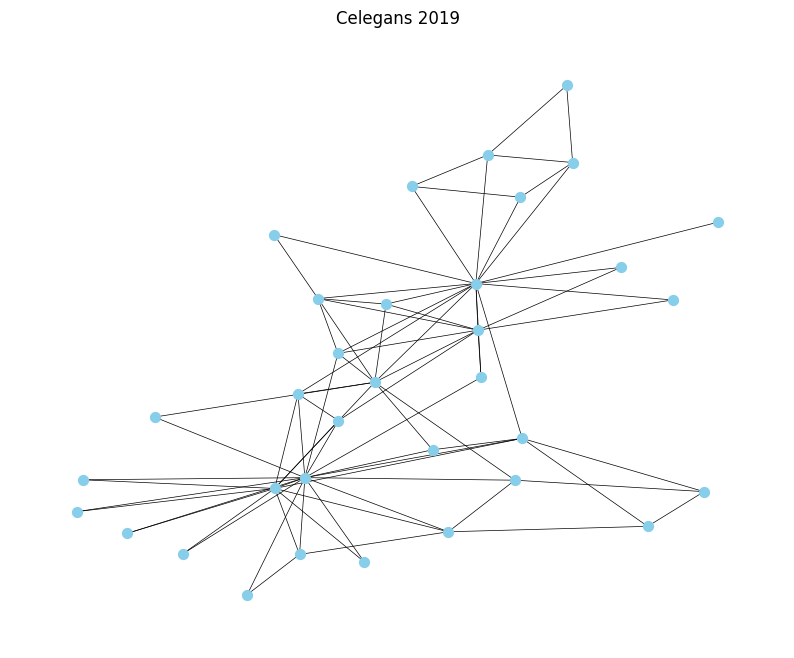

In [6]:
def plot_graph(G_nx, ax, title):
    """
    Função para plotar um grafo em um eixo específico.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo
    nx.draw(
        G_nx, pos,
        ax=ax,
        with_labels=False,  # Remover rótulos
        node_color='skyblue',  # Nós na cor azul claro
        edge_color='black',  # Arestas na cor preta
        node_size=50,  # Tamanho maior dos nós
        width=0.5,  # Largura das arestas
        font_size=8,  # Tamanho da fonte dos rótulos, se habilitados
        font_weight='bold',
        arrows=False  # Desabilitar setas para grafos não direcionados
    )
    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar o grafo no eixo
plot_graph(G_celegans, ax, "Celegans 2019")

# Mostrar o gráfico
plt.show()


**Exercício 1.** Selecione uma rede com estrutura de comunidades clara e que tenha um
tamanho razoável, evitando redes muito pequenas. Certifique-se de que exista uma partição de referência para a rede escolhida. Utilize ao menos quatro métodos de detecção de
comunidades, entre os discutidos ou mencionados em aula.

#### Função para calcular a modularidade

In [7]:
def modularity(G, c):
    A = nx.adjacency_matrix(G)
    N = len(G)
    M = G.number_of_edges()
    Q = 0
    for i in np.arange(0, N):
        ki = len(list(G.neighbors(i)))
        for j in np.arange(0, N):
            if c[i] == c[j]:
                kj = len(list(G.neighbors(j)))
                Q += A[i, j] - (ki * kj) / (2 * M)
    Q /= (2 * M)
    return Q


#### Função para plotar as comunidades

In [8]:
def plot_communities(G_nx, communities, colors, ax, title):
    """
    Função para plotar um grafo com comunidades destacadas em um eixo específico.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    communities (list): Lista de comunidades extraídas do grafo.
    colors (list): Lista de cores para cada comunidade.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo

    # Desenhar as arestas
    nx.draw_networkx_edges(G_nx, pos, ax=ax, edge_color='black', width=0.2)

    # Desenhando cada subgrafo de comunidade com a cor correspondente
    for aux, cm in enumerate(communities):
        nx.draw(
            G_nx.subgraph(cm), pos=pos, ax=ax,
            node_color=colors[aux],
            with_labels=False,  # Sem rótulos
            node_size=50,  # Tamanho dos nós
            edge_color='none'  # Sem bordas para os nós da comunidade
        )

    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

#### Utilizando o método de Girvan-Newman

In [9]:
# Selecionar a rede
G = process_graph("jazz_collab", directed=False)
G = nx.convert_node_labels_to_integers(G, first_label=0)

# 1. Método de Girvan-Newman
communities_generator = nx_comm.girvan_newman(G)
k = 2  # Número de comunidades a serem extraídas

# Extraindo as comunidades no nível k
for _ in range(k - 1):
    next_level_communities = next(communities_generator)

# Convertendo para lista de comunidades
c = list(next_level_communities)

# Inicializa a array de comunidades
communities = np.zeros(len(G.nodes()), dtype=int)

for nc, community in enumerate(c):
    communities[list(community)] = nc
    print("Community:", sorted(community))

# Calculando a modularidade
Q = modularity(G, communities)
print("Modularity Q =", Q)

# Criando uma lista de partições
partitions = [list(community) for community in c]

# Calculando a modularidade para cada sub-comunidade
for nc, community in enumerate(partitions):
    # Criar um subgrafo para a comunidade
    subgraph = G.subgraph(community)

    # Calculando a modularidade da sub-comunidade
    Q_sub = nx_comm.modularity(subgraph, [community])  # Passando a subcomunidade como uma lista
    print(f"Modularity Q for community {nc} =", Q_sub)

Grafo: jazz_collab
Número de nós: 198
Número de arestas: 2742
Community: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
Community: [106, 111, 112, 165]
Modularity Q = 0.00362994848484358

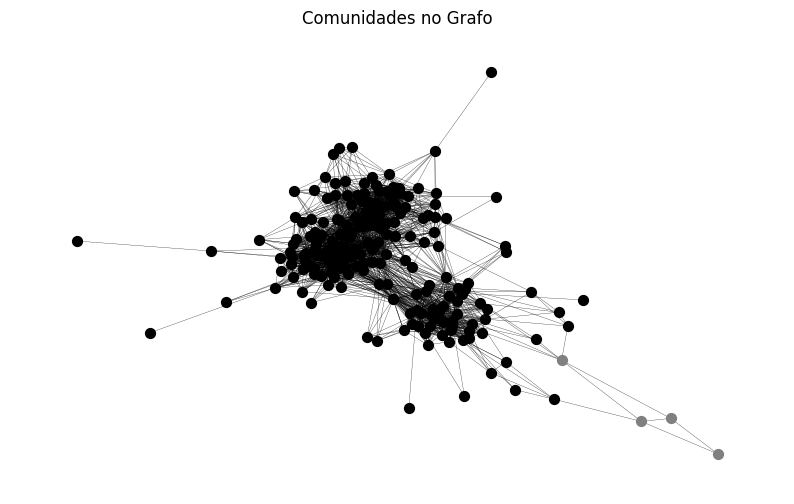

In [10]:
# Definindo as cores para a visualização
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar as comunidades no eixo
plot_communities(G, c, colors, ax, "Comunidades no Grafo")

# Exibir a figura
plt.show()

#### Método FastGreed

In [11]:
# Encontrar comunidades usando o método de modularidade gananciosa
c = list(greedy_modularity_communities(G))

# Inicializa a array de comunidades
communities = np.zeros(len(G.nodes()), dtype=int)

# Atribui um índice de comunidade para cada nó
for nc, community in enumerate(c):
    communities[list(community)] = nc
    print("Community:", sorted(community))

# Calculando a modularidade para cada comunidade
for nc, community in enumerate(c):
    sub_communities = np.zeros(len(G.nodes()), dtype=int)
    sub_communities[list(community)] = nc  # Atribui o índice da comunidade
    Q_sub = modularity(G, sub_communities)
    print(f"Modularity Q for community {nc} =", Q_sub)

# Calculando a modularidade total
Q_total = modularity(G, communities)
print("Total Modularity Q =", Q_total)

Community: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 89, 92, 161, 170, 171, 172, 175, 176, 178, 179, 180, 183, 184, 185, 186, 191]
Community: [24, 26, 27, 29, 30, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 132, 138, 155, 156, 157, 158, 159, 162, 166, 167, 168, 169, 173, 174, 177, 181, 189, 190, 197]
Community: [28, 63, 96, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 160, 163, 164, 165, 182, 192, 193, 194, 195, 196]
Community: [91, 187, 188]
Modularity Q for community 0 = -1.4706137840170894e-17
Modularity Q for 

#### Plotando as comunidades

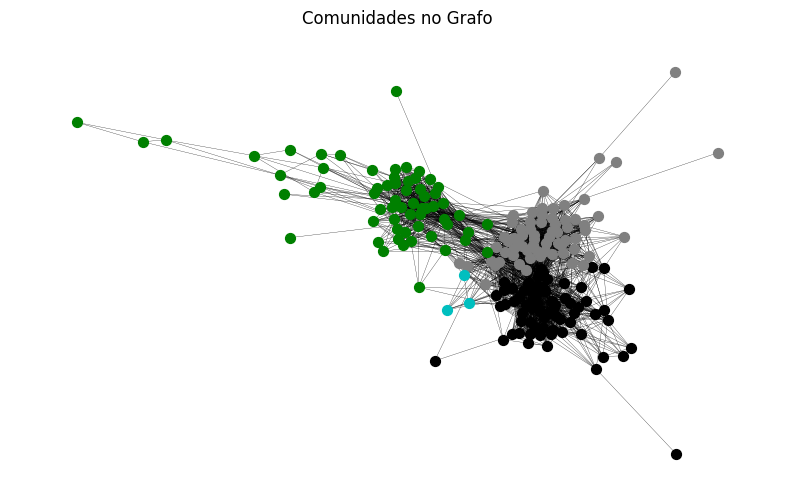

In [12]:
# Definindo as cores para a visualização
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar as comunidades no eixo
plot_communities(G, c, colors, ax, "Comunidades no Grafo")

# Exibir a figura
plt.show()

#### Método de Louvain

In [16]:
# Encontra a estrutura de comunidades usando o método Louvain e faz uma lista de cada comunidade
communities = community_louvain.best_partition(G)  # Aplica o algoritmo Louvain e armazena as comunidades encontradas

# Inicializa um array de zeros para armazenar os índices das comunidades
communities_indices = np.zeros(len(G.nodes()), dtype=int)

# Preenche o array com os índices das comunidades correspondentes a cada nó
for node, community in communities.items():
    communities_indices[node] = community

# Imprime as comunidades e seus nós
num_communities = max(communities.values()) + 1
for k in range(num_communities):
    community_nodes = [node for node, com in communities.items() if com == k]
    print(f'Community {k}:', sorted(community_nodes))

# Calcula e imprime a modularidade total baseada nas comunidades
overall_Q = community_louvain.modularity(communities, G)
print("Overall Modularity Q =", overall_Q)

# Calcula e imprime a modularidade para cada comunidade
for k in range(num_communities):
    # Obtém os nós pertencentes à comunidade k
    community_nodes = [node for node, com in communities.items() if com == k]

    # Verifica se existem nós na comunidade
    if len(community_nodes) > 0:
        subgraph = G.subgraph(community_nodes)  # Cria um subgrafo apenas com os nós da comunidade
        try:
            # Calcula a modularidade da sub-comunidade
            sub_communities = {node: k for node in community_nodes}
            Q_sub = community_louvain.modularity(sub_communities, subgraph)
            print(f"Modularity Q for community {k} = {Q_sub:.4f}")  # Imprime a modularidade para a comunidade k
        except Exception as e:
            print(f"Error calculating modularity for community {k}: {e}")
    else:
        print(f"Community {k} is empty, skipping modularity calculation.")


Community 0: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 89, 92, 161, 170, 171, 172, 175, 176, 178, 179, 180, 183, 184, 186, 191]
Community 1: [7, 15, 21, 24, 26, 27, 28, 29, 30, 53, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 132, 138, 155, 156, 157, 158, 159, 162, 166, 167, 168, 169, 173, 174, 177, 181, 182, 185, 187, 188, 189, 190, 197]
Community 2: [63, 96, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 160, 163, 164, 165, 192, 193, 194, 195, 196]
Overall Modularity Q = 0.44131239688855484
Modularity Q for community 0 = 0.00

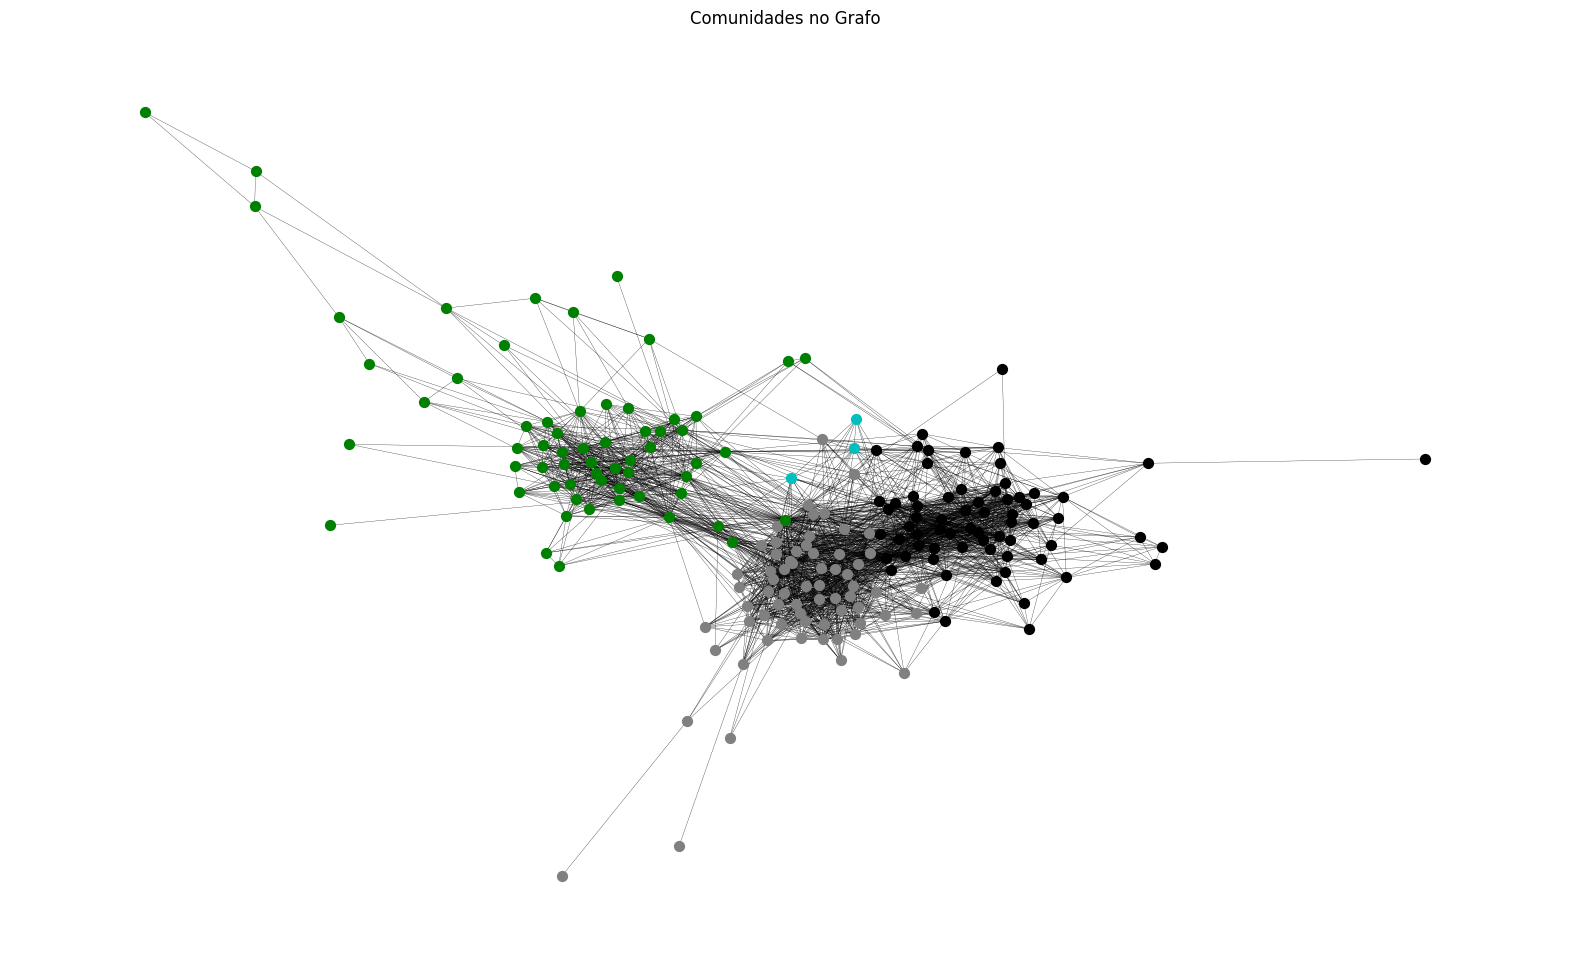

In [14]:
# Definindo as cores para a visualização
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 12))

# Plotar as comunidades no eixo
plot_communities(G, c, colors, ax, "Comunidades no Grafo")

# Exibir a figura
plt.show()

In [15]:
sfdfdfd

NameError: name 'sfdfdfd' is not defined

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community as nx_comm

# Selecionar a rede (adjnoun como exemplo)
G = process_graph("karate/78", directed=False)

# 1. Método de Girvan-Newman
communities = nx_comm.girvan_newman(G)
k = 4  # Número de comunidades a serem extraídas

# Extraindo as comunidades no nível k
for i in range(k - 1):
    next_level_communities = next(communities)

# Ordenando as comunidades
c = sorted(map(sorted, next_level_communities))

# Definindo as cores para a visualização
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']
pos = nx.spring_layout(G)  # Posicionamento dos nós

# Visualização das comunidades
fig = plt.figure(figsize=(10, 6))
nx.draw(G, pos=pos, node_color='white', edge_color='lightgray')

# Desenhando cada subgrafo de comunidade com a cor correspondente
aux = 0
for cm in c:
    nx.draw(G.subgraph(cm), pos=pos, node_color=colors[aux],
            with_labels=False, node_size=300, edge_color='none')  # Sem bordas
    aux += 1

# Exibindo a figura
plt.show()
